# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 20.10.2020

Мягкий дедлайн: 01:59MSK 02.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 01:59MSK 05.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [81]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [82]:
from sklearn.svm import SVC

In [83]:
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV

c_linspace = np.linspace(0.1, 4, 15)
searcher = GridSearchCV(SVC(kernel='linear'), [{'C': c_linspace}], scoring=make_scorer(roc_auc_score), cv=5)
searcher.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([0.1       , 0.37857143, 0.65714286, 0.93571429, 1.21428571,
       1.49285714, 1.77142857, 2.05      , 2.32857143, 2.60714286,
       2.88571429, 3.16428571, 3.44285714, 3.72142857, 4.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(roc_auc_score), verbose=0)

In [84]:
best_c = searcher.best_params_['C']
print(best_c)

0.1


На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью sklearn можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты.


In [85]:
svm = SVC(kernel='linear', C=best_c, probability=True)
svm.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [86]:
y_pred = svm.decision_function(X_test)

In [87]:
y_pred

array([ 0.757276  , -3.66046838, -1.14450991, ..., -2.1484912 ,
        1.59994678,  2.14189499])

In [88]:
from sklearn.metrics import precision_recall_curve, auc
y_random = np.random.random(size=len(y_pred))

In [90]:
pr_test,rec_test,thr_test = precision_recall_curve(y_test, y_pred)
print('SVM') 
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred)}')
print(f'AUC-PR: {auc(rec_test, pr_test)}\n')

pr_random,rec_random,thr_random = precision_recall_curve(y_test, y_random)
print('Random model')
print(f'AUC-ROC: {roc_auc_score(y_test, y_random)}')
print(f'AUC-PR: {auc(rec_random, pr_random)}')

SVM
AUC-ROC: 0.8478955741426343
AUC-PR: 0.8148590524794197

Random model
AUC-ROC: 0.49721408660934674
AUC-PR: 0.49080859146301903


In [91]:
from sklearn.metrics import roc_curve
fpr_pred, tpr_pred = roc_curve(y_test, y_pred)[:2]
fpr_random, tpr_random = roc_curve(y_test, y_random)[:2]

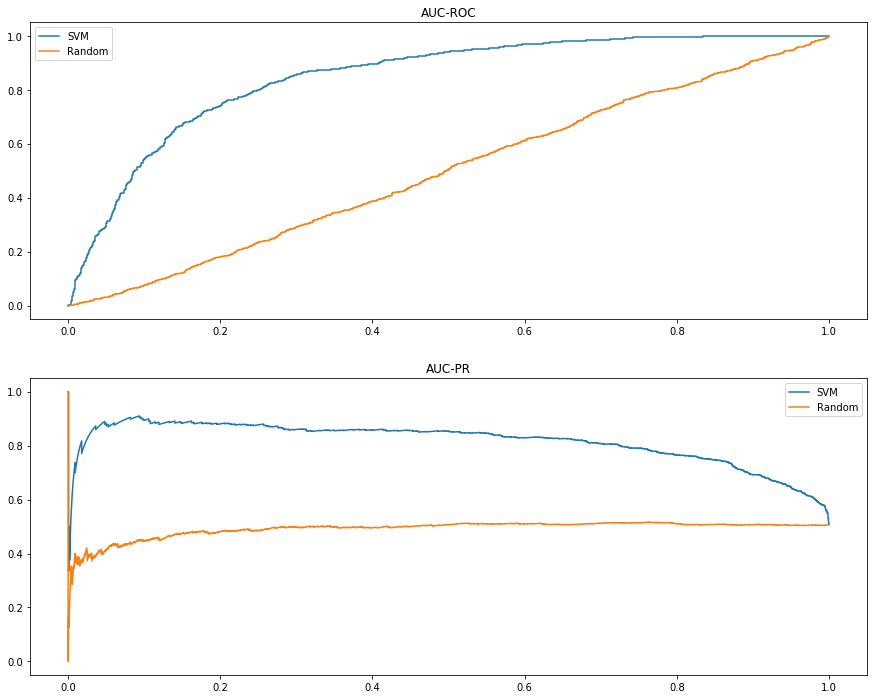

In [92]:
fig, ax = plt.subplots(2, 1, figsize=(15,12))
ax[0].plot(fpr_pred, tpr_pred, label='SVM')
ax[1].plot(rec_test, pr_test, label='SVM')
ax[0].plot(fpr_random, tpr_random, label='Random')
ax[1].plot(rec_random, pr_random, label='Random')

ax[0].set_title('AUC-ROC')
ax[1].set_title('AUC-PR')

ax[0].legend()
ax[1].legend()
plt.show()

Ожидаемо лучше чем на рандомном классификаторе. У рандомного также ожидаемо roc-auc близок к диагональному

А вот поведение AUC-PR я до конца объяснить не могу 

Для каждой из метрик есть два способа: либо посчитать, пользуясь встроенными функциями подсчёта метрики, либо подсчитать fpr, tpr используя roc_curve (и аналогичные показатели и функцию для AUC-PR) и дальше посчитать площадь через auc. 

Вроде как эти варианты между собой не различаются (просто один это реализованный другой)

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [93]:
from sklearn.linear_model import LogisticRegression

c_linspace = np.linspace(0.25, 5, 15)
searcher = GridSearchCV(LogisticRegression(solver='lbfgs'), [{'C': c_linspace}], scoring=make_scorer(roc_auc_score), cv=5)
searcher.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([0.25      , 0.58928571, 0.92857143, 1.26785714, 1.60714286,
       1.94642857, 2.28571429, 2.625     , 2.96428571, 3.30357143,
       3.64285714, 3.98214286, 4.32142857, 4.66071429, 5.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scor

In [94]:
best_c_logreg = searcher.best_params_['C']

In [95]:
logit = LogisticRegression(C=best_c_logreg, solver='lbfgs')
logit.fit(X_train, y_train)

LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
logit_probas = logit.predict_proba(X_test)
logit_probas

array([[0.29145527, 0.70854473],
       [0.98754388, 0.01245612],
       [0.82079759, 0.17920241],
       ...,
       [0.9400995 , 0.0599005 ],
       [0.13530364, 0.86469636],
       [0.07155446, 0.92844554]])

In [97]:
pr_test,rec_test,thr_test = precision_recall_curve(y_test, logit_probas[:, 1])
print('Logistic regression') 
print(f'AUC-ROC: {roc_auc_score(y_test, logit_probas[:, 1])}')
print(f'AUC-PR: {auc(rec_test, pr_test)}\n')

Logistic regression
AUC-ROC: 0.8478715710595716
AUC-PR: 0.8291440467036588



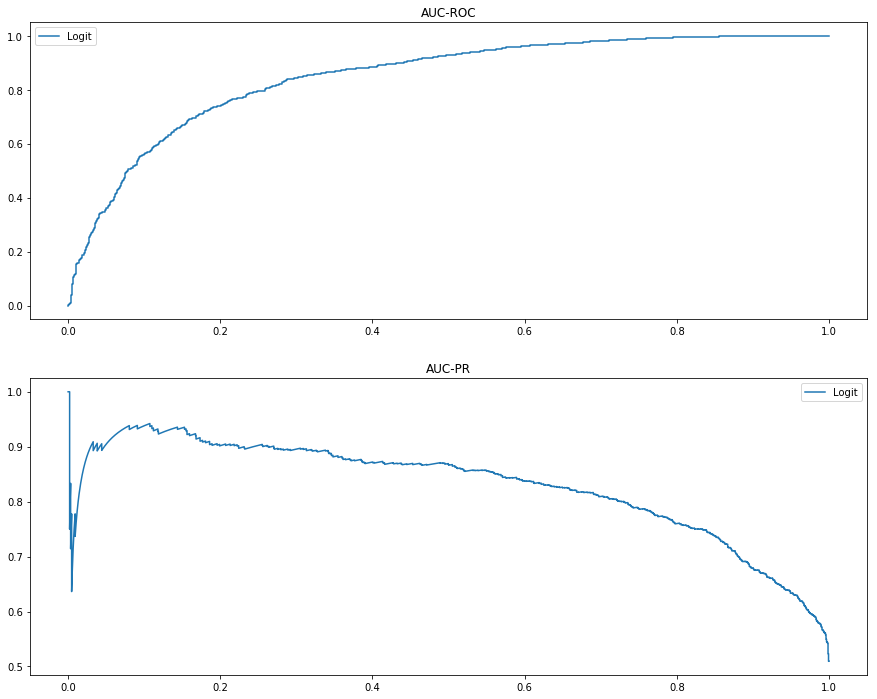

In [98]:
fpr_pred, tpr_pred = roc_curve(y_test, logit_probas[:, 1])[:2]
fig, ax = plt.subplots(2, 1, figsize=(15,12))
ax[0].plot(fpr_pred, tpr_pred, label='Logit')
ax[1].plot(rec_test, pr_test, label='Logit')

ax[0].set_title('AUC-ROC')
ax[1].set_title('AUC-PR')

ax[0].legend()
ax[1].legend()
plt.show()

AUC-ROC получился почти одинаковым. AUC-PR выше у логистической регрессии, но не сильно. Кажется, статистически значимых отличий нет

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [99]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42
                          )
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

c_linspace = np.linspace(0.25, 5, 15)
searcher = GridSearchCV(SVC(kernel='linear'), [{'C': c_linspace}], scoring=make_scorer(roc_auc_score), cv=5)
searcher.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([0.25      , 0.58928571, 0.92857143, 1.26785714, 1.60714286,
       1.94642857, 2.28571429, 2.625     , 2.96428571, 3.30357143,
       3.64285714, 3.98214286, 4.32142857, 4.66071429, 5.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(roc_auc_score), verbose=0)

In [101]:
best_c_svm = searcher.best_params_['C']
best_c_svm

0.25

In [102]:
svm = SVC(C=best_c_svm, kernel='linear')
svm.fit(X_train, y_train)

SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [103]:
vectors = svm.support_vectors_
vectors

array([[ 1.01355564, -0.41963808],
       [-1.34456334,  0.25414983],
       [ 1.32704558, -0.31936361],
       ...,
       [ 0.05528074, -0.04778752],
       [ 0.584125  , -0.1247789 ],
       [-1.16333013,  0.79249276]])

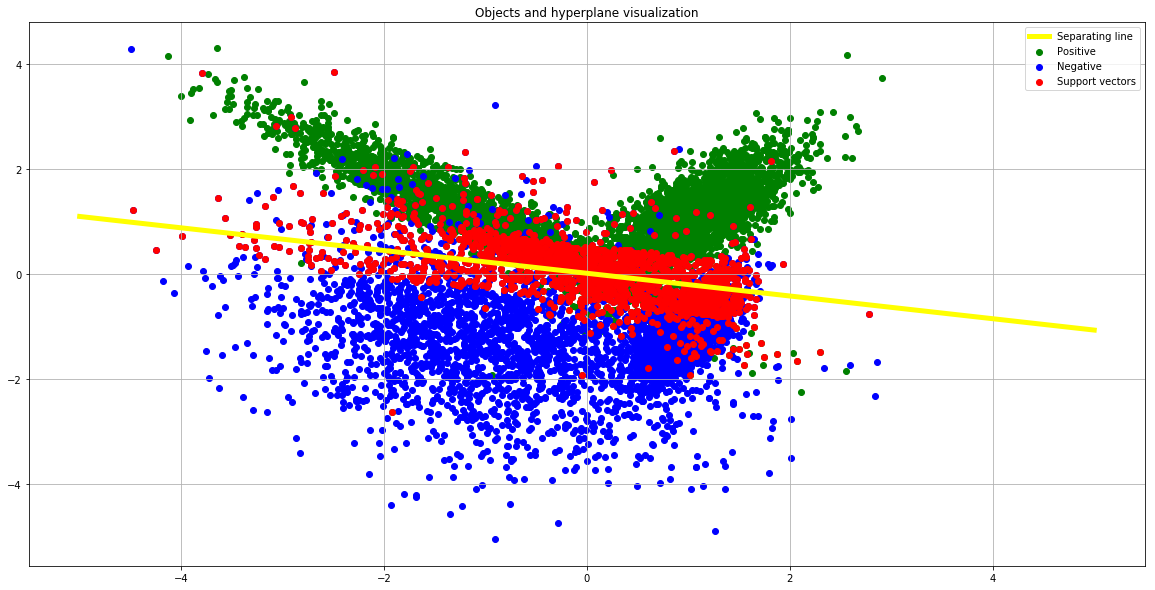

In [104]:
w = svm.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (svm.intercept_[0]) / w[1]

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(X[y>0][:, 0], X[y>0][:, 1], color='green', label='Positive')
ax.scatter(X[y==0][:, 0], X[y==0][:, 1], color='blue', label='Negative')
ax.scatter(vectors[:, 0], vectors[:, 1], color='red', label='Support vectors')
ax.plot(xx, yy, color='yellow', linewidth=5, label='Separating line')
ax.set_title('Objects and hyperplane visualization')
ax.legend()
ax.grid()
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость, а приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [105]:
#your code here

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [135]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append(l + (r - l) / 2) 
        bin_real_ratios.append(np.sum(y_test[((preds >= l) & (preds < r))]) / len(y_test[(preds >= l) & (preds < r)])) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [136]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [147]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train, y_train)

/Users/danyasedashov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [148]:
svm_pred = svm.decision_function(X_test)
svm_pred = 1 / (1 + np.exp(-1 * svm_pred))
svm_pred

array([0.57912157, 0.16670011, 0.36402497, ..., 0.2673706 , 0.66278757,
       0.72029415])

In [149]:
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)

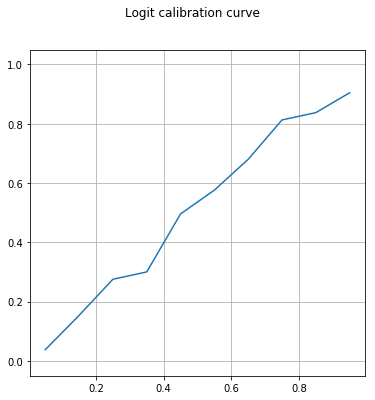

In [150]:
plot_calibration_curve(y_test, logit_pred[:, 1])
plt.suptitle('Logit calibration curve')
plt.show()

/Users/danyasedashov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


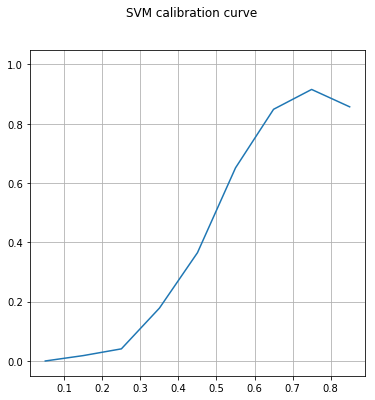

In [151]:
plot_calibration_curve(y_test, svm_pred)
plt.suptitle('SVM calibration curve')
plt.show()

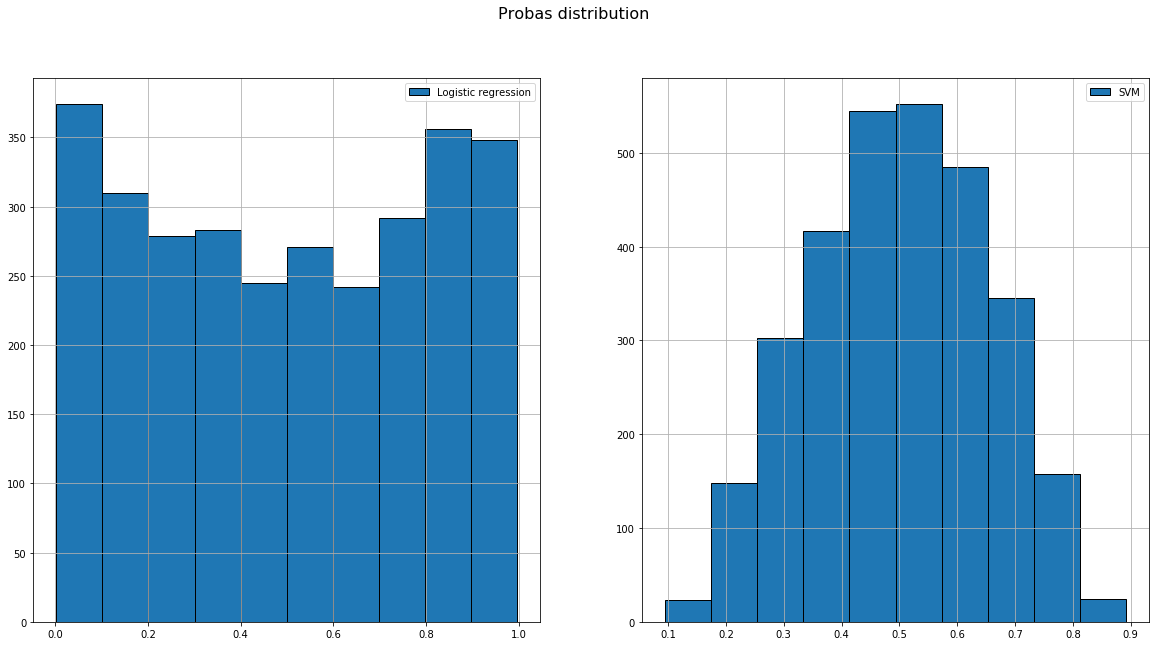

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(logit_pred[:, 1], label='Logistic regression', bins=10, ec='black')
ax[1].hist(svm_pred, label='SVM', bins=10, ec='black')

ax[0].grid()
ax[0].legend()
ax[1].grid()
ax[1].legend()

fig.suptitle('Probas distribution', fontsize=16)
plt.show()

Отличаются они потому, что SVM, вообще говоря, не стремится оптимизировать вероятности (а именно, ему без разницы, какой отступ, если он больше единицы), и в целом тут можно ожидать что-то похожее на нормальное распределение. Logit же максимизирует отступ и поэтому даёт более приличные оценки вероятностей

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [155]:
from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(LinearSVC(max_iter=5000))
calibrated.fit(X_train, y_train)

/Users/danyasedashov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=5000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv='warn', method='sigmoid')

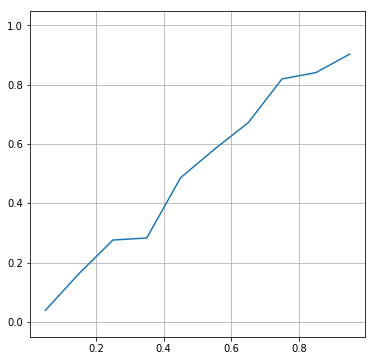

In [156]:
calibrated_predicts = calibrated.predict_proba(X_test)
plot_calibration_curve(y_test, calibrated_predicts[:, 1])

После калибровки кривая заметно улучшилась, как и ожидалось

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [47]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [70]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2020-11-01 15:13:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 444572 (434K) [application/x-httpd-php]
Сохранение в: «bank-additional.zip.1»

bank-additional.zip 100%[===================>] 434,15K   141KB/s    за 3,1s    

2020-11-01 15:13:11 (141 KB/s) - «bank-additional.zip.1» сохранён [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [157]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [263]:
y = df['y'].apply(lambda x: 0 if x == 'no' else 1)
X = df.drop(columns=['y'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [264]:
import warnings
warnings.filterwarnings('ignore')

In [265]:
# длительность не известна до того как мы делаем звонок, при этом она может влиять на целевую переменную (= 0 => ответ нет)
X_train.drop(columns=['duration'], inplace=True)
X_test.drop(columns=['duration'], inplace=True)

In [266]:
y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: `AUC-PR` более чувствителен к задачам, в которых наблюдается имбаланс классов, а здесь как раз такой случай (см. наверх)

In [267]:
from sklearn.preprocessing import OrdinalEncoder

categorical = [
    'job', 'marital', 'education',
    'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week',
    'poutcome'
]

In [268]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

col_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), categorical)
])

pipeline = Pipeline(steps=[
    ('encoding', col_transformer),
    ('logit', LogisticRegression(solver='lbfgs'))
])


In [269]:
%%timeit
model = pipeline.fit(X_train, y_train)

10 loops, best of 5: 158 ms per loop


In [270]:
model = pipeline.fit(X_train, y_train)

In [271]:
pred = model.predict_proba(X_test)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])
print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.3064820299857385


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [272]:
from sklearn.preprocessing import OneHotEncoder

col_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical)
])

pipeline = Pipeline(steps=[
    ('encoding', col_transformer),
    ('logit', LogisticRegression(solver='lbfgs'))
])



In [273]:
%%timeit
model2 = pipeline.fit(X_train, y_train)

1 loop, best of 5: 262 ms per loop


In [274]:
model2 = pipeline.fit(X_train, y_train)

In [275]:
pred = model2.predict_proba(X_test)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])
print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.40696907414037914


Времени потребовалось больше, но и качество возросло 

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [292]:
from sklearn.base import TransformerMixin, BaseEstimator

class SimpleCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.cat = categorical
    
    def fit(self, X, y):
        # compute mean values
        # idk how to vectorize it more
        self.avg = {}
        for feature in self.cat:
            gby = X.groupby(feature)
            indexes, keys = list(gby.groups.values()), list(gby.groups.keys())
            self.avg.update({feature: {keys[i]: y[indexes[i]].mean() for i in range(len(keys))}})
        return self
    
    def transform(self, X):
        X_c = X.copy()
        for feature in self.cat:
            X_c.loc[:, feature] = X_c.loc[:, feature].replace(self.avg[feature])
        return X_c
            
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [293]:
categorical = [
    'job', 'marital', 'education',
    'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week',
    'poutcome'
]
c = SimpleCounterTransformer(categorical=categorical)
c.fit(X_train, y_train)

SimpleCounterTransformer(categorical=None)

In [296]:
%%timeit
c = SimpleCounterTransformer(categorical=categorical)
c.fit(X_train, y_train)
X_train_counted = c.transform(X_train)
X_test_counted = c.transform(X_test)
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_counted, y_train)
pred = logit.predict_proba(X_test_counted)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])
print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.417416651034744
AUC PR: 0.417416651034744
AUC PR: 0.417416651034744
AUC PR: 0.417416651034744
AUC PR: 0.417416651034744
AUC PR: 0.417416651034744
1 loop, best of 5: 427 ms per loop


Качество немного улучшилось

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [306]:
class NoisyCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.cat = categorical
    
    def fit(self, X, y):
        # compute mean values
        # idk how to vectorize it more
        self.avg = {}
        for feature in self.cat:
            gby = X.groupby(feature)
            indexes, keys = list(gby.groups.values()), list(gby.groups.keys())
            self.avg.update({feature: {keys[i]: y[indexes[i]].mean() for i in range(len(keys))}})
        return self
    
    def transform(self, X):
        X_c = X.copy()
        for feature in self.cat:
            X_c.loc[:, feature] = X_c.loc[:, feature].replace(self.avg[feature]) + np.random.normal(0, 0.05, X_c.shape[0])
        return X_c
            
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)


In [307]:
%%timeit
c = NoisyCounterTransformer(categorical=categorical)
c.fit(X_train, y_train)
X_train_counted = c.transform(X_train)
X_test_counted = c.transform(X_test)
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_counted, y_train)
pred = logit.predict_proba(X_test_counted)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])
print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.4183992445133223
AUC PR: 0.40761670018232266
AUC PR: 0.4173977608739131
AUC PR: 0.4171587439082561
AUC PR: 0.4186114927677347
AUC PR: 0.4154630927268038
1 loop, best of 5: 563 ms per loop


В среднем качество не улучшилось: иногда чуть лучше, иногда чуть хуже чем до этого. Возможно, стоит чуть лучше подбирать шум

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [72]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [315]:
class SmoothCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical, C=10):
        self.cat = categorical
        self.C = C
    
    def fit(self, X, y):
        # compute mean values
        # idk how to vectorize it more
        self.global_mean = np.sum(y) / len(y)
        self.avg = {}
        for feature in self.cat:
            gby = X.groupby(feature)
            indexes, keys = list(gby.groups.values()), list(gby.groups.keys())
            self.avg.update({feature: {keys[i]: (y[indexes[i]].sum() + self.C * self.global_mean) /
                                       (len(indexes[i]) + self.C) for i in range(len(keys))}})
        return self
    
    def transform(self, X):
        X_c = X.copy()
        for feature in self.cat:
            X_c.loc[:, feature] = X_c.loc[:, feature].replace(self.avg[feature]) + np.random.normal(0, 0.05, X_c.shape[0])
        return X_c
            
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)



In [316]:
%%timeit
c = SmoothCounterTransformer(categorical=categorical, C=10)
c.fit(X_train, y_train)
X_train_counted = c.transform(X_train)
X_test_counted = c.transform(X_test)
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_counted, y_train)
pred = logit.predict_proba(X_test_counted)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])
print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.41799549395915164
AUC PR: 0.4200938550366232
AUC PR: 0.4185171940089878
AUC PR: 0.41814242498789045
AUC PR: 0.41120902690255917
AUC PR: 0.4197055357559452
1 loop, best of 5: 466 ms per loop


Качество опять незначительно меняется в третьем знаке после запятой

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [317]:
X_train['age'].nunique()

76

In [318]:
categorical = [
    'job', 'marital', 'education',
    'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week',
    'poutcome', 'age',
]

In [320]:
%%timeit
c = SmoothCounterTransformer(categorical=categorical, C=10)
c.fit(X_train, y_train)
X_train_counted = c.transform(X_train)
X_test_counted = c.transform(X_test)
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_counted, y_train)
pred = logit.predict_proba(X_test_counted)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])
print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.42875838273216793
AUC PR: 0.4194406667351995
AUC PR: 0.4288522275564265
AUC PR: 0.41877769175302465
AUC PR: 0.4274066667638094
AUC PR: 0.41978709269700953
1 loop, best of 5: 494 ms per loop


Стало чуть лучше. Действительно, интерпретировать возраст как числовой признак довольно странно

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [321]:
categorical = [
    'job', 'marital', 'education',
    'default', 'housing', 'loan',
    'contact', 'poutcome', 'age',
]

In [326]:
months = {
    'jan': 0,
    'feb': 1,
    'mar': 2,
    'apr': 3,
    'may': 4,
    'jun': 5,
    'jul': 6,
    'aug': 7,
    'sep': 8,
    'oct': 9,
    'nov': 10,
    'dec': 11
}

weekdays = {
    'mon': 0,
    'tue': 1,
    'wed': 2,
    'thu': 3,
    'fri': 4
}

In [327]:
%%timeit
c = SmoothCounterTransformer(categorical=categorical, C=10)
c.fit(X_train, y_train)
X_train_counted = c.transform(X_train)
X_train_counted.loc[:, 'day_of_week'] = X_train_counted['day_of_week'].replace(weekdays)
X_train_counted.loc[:, 'month'] = X_train_counted['month'].replace(months)
X_test_counted = c.transform(X_test)
X_test_counted.loc[:, 'day_of_week'] = X_test_counted['day_of_week'].replace(weekdays)
X_test_counted.loc[:, 'month'] = X_test_counted['month'].replace(months)
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_counted, y_train)
pred = logit.predict_proba(X_test_counted)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])
print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.4140360664724619
AUC PR: 0.41438364577287434
AUC PR: 0.4143023498444979
AUC PR: 0.41467107734383574
AUC PR: 0.41377220332832204
AUC PR: 0.41438714513900216
1 loop, best of 5: 508 ms per loop


Ожидаемо просели по качеству. Вводить порядок на днях недели и месяцах странно, потому что мы понятия не имеем о том, есть ли линейный тренд, зависящий от порядкового номера дня недели или месяца

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

Плюсы: не увеличиваем признаковое пространство, получаем более репрезентативные признаки (о чём свидетельствует улучшение качества, пусть и небольшое)

Минусы: утечка таргета в признаки, дольше преобразовываются данные 

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [465]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [466]:
categorical = [
    'job', 'marital', 'education',
    'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week',
    'poutcome'
]

In [467]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[categorical])

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [468]:
transformed = ohe.transform(X_train[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X_train_ohe.index
X_train_ohe = X_train.join(ohe_df.reindex(X_train_ohe.index)).drop(columns=categorical)

In [469]:
X_train_ohe.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,x0_admin.,x0_blue-collar,x0_entrepreneur,x0_housemaid,x0_management,x0_retired,x0_self-employed,x0_services,x0_student,x0_technician,x0_unemployed,x0_unknown,x1_divorced,x1_married,x1_single,x1_unknown,x2_basic.4y,x2_basic.6y,x2_basic.9y,x2_high.school,x2_illiterate,x2_professional.course,x2_university.degree,x2_unknown,x3_no,x3_unknown,x3_yes,x4_no,x4_unknown,x4_yes,x5_no,x5_unknown,x5_yes,x6_cellular,x6_telephone,x7_apr,x7_aug,x7_dec,x7_jul,x7_jun,x7_mar,x7_may,x7_nov,x7_oct,x7_sep,x8_fri,x8_mon,x8_thu,x8_tue,x8_wed,x9_failure,x9_nonexistent,x9_success
24486,38,2,999,0,-0.1,93.200,-42.0,4.191,5195.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20631,33,1,999,0,1.4,93.444,-36.1,4.965,5228.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
33638,34,2,999,0,-1.8,92.893,-46.2,1.281,5099.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
18407,27,1,999,0,1.4,93.918,-42.7,4.968,5228.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
33138,40,1,999,0,-1.8,92.893,-46.2,1.291,5099.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [470]:
X_train_ohe.shape

(32950, 62)

Получили 62 признака

In [471]:
transformed = ohe.transform(X_test[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X_test_ohe.index
X_test_ohe = X_test.join(ohe_df).drop(columns=categorical)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [472]:
%%timeit

logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_ohe, y_train)
pred = logit.predict_proba(X_test_ohe)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])
print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.42978411388735954
AUC PR: 0.42978411388735954
AUC PR: 0.42978411388735954
AUC PR: 0.42978411388735954
AUC PR: 0.42978411388735954
AUC PR: 0.42978411388735954
1 loop, best of 5: 357 ms per loop


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [481]:
%%timeit
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_ohe, y_train)
pred = logit.predict_proba(X_test_ohe)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])

coefs = logit.coef_[0]
indices = (-np.abs(coefs)).argsort()[:40]
X_train_restr = X_train_ohe.to_numpy()[:, indices]
X_test_restr = X_test_ohe.to_numpy()[:, indices]

logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_restr, y_train)
pred = logit.predict_proba(X_test_restr)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])

print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.43884495905893767
AUC PR: 0.43884495905893767
AUC PR: 0.43884495905893767
AUC PR: 0.43884495905893767
AUC PR: 0.43884495905893767
AUC PR: 0.43884495905893767
1 loop, best of 5: 597 ms per loop


Качество немного выросло

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [486]:
# зафиттим скейлер на трейне и отскейлим трейн

from sklearn.preprocessing import StandardScaler

numeric = [
    'age', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric]), columns=numeric)
scaled.index = X_train.index
X_train_scaled = X_train.drop(columns=numeric).join(scaled)
X_train_scaled.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
24486,technician,married,professional.course,no,yes,no,cellular,nov,mon,nonexistent,-0.192804,-0.203761,0.193904,-0.349055,-0.118593,-0.652576,-0.324949,0.325980,0.395485
20631,technician,married,high.school,no,no,no,cellular,aug,wed,nonexistent,-0.672942,-0.568411,0.193904,-0.349055,0.837041,-0.231436,0.951771,0.772563,0.841655
33638,services,divorced,basic.6y,unknown,yes,no,cellular,may,wed,nonexistent,-0.576915,-0.203761,0.193904,-0.349055,-1.201646,-1.182453,-1.233800,-1.353033,-0.940262
18407,blue-collar,single,basic.4y,no,no,no,cellular,jul,thu,nonexistent,-1.249108,-0.568411,0.193904,-0.349055,0.837041,0.586681,-0.476424,0.774294,0.841655
33138,services,married,basic.9y,no,yes,yes,cellular,may,tue,nonexistent,-0.000749,-0.568411,0.193904,-0.349055,-1.201646,-1.182453,-1.233800,-1.347264,-0.940262


In [487]:
# отскейлим тест

scaled = pd.DataFrame(scaler.transform(X_test[numeric]), columns=numeric)
scaled.index = X_test.index
X_test_scaled = X_test.drop(columns=numeric).join(scaled)

In [488]:
# ванхотим категориальные на трейне

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_scaled[categorical])
transformed = ohe.transform(X_train_scaled[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X_train_scaled.index
X_train_ohe = X_train_scaled.join(ohe_df).drop(columns=categorical)

In [489]:
X_train_ohe.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,x0_admin.,x0_blue-collar,x0_entrepreneur,x0_housemaid,x0_management,x0_retired,x0_self-employed,x0_services,x0_student,x0_technician,x0_unemployed,x0_unknown,x1_divorced,x1_married,x1_single,x1_unknown,x2_basic.4y,x2_basic.6y,x2_basic.9y,x2_high.school,x2_illiterate,x2_professional.course,x2_university.degree,x2_unknown,x3_no,x3_unknown,x3_yes,x4_no,x4_unknown,x4_yes,x5_no,x5_unknown,x5_yes,x6_cellular,x6_telephone,x7_apr,x7_aug,x7_dec,x7_jul,x7_jun,x7_mar,x7_may,x7_nov,x7_oct,x7_sep,x8_fri,x8_mon,x8_thu,x8_tue,x8_wed,x9_failure,x9_nonexistent,x9_success
24486,-0.192804,-0.203761,0.193904,-0.349055,-0.118593,-0.652576,-0.324949,0.325980,0.395485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20631,-0.672942,-0.568411,0.193904,-0.349055,0.837041,-0.231436,0.951771,0.772563,0.841655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
33638,-0.576915,-0.203761,0.193904,-0.349055,-1.201646,-1.182453,-1.233800,-1.353033,-0.940262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
18407,-1.249108,-0.568411,0.193904,-0.349055,0.837041,0.586681,-0.476424,0.774294,0.841655,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
33138,-0.000749,-0.568411,0.193904,-0.349055,-1.201646,-1.182453,-1.233800,-1.347264,-0.940262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [490]:
# и на тесте

transformed = ohe.transform(X_test_scaled[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X_test_scaled.index
X_test_ohe = X_test_scaled.join(ohe_df).drop(columns=categorical)

In [495]:
# обучаем регрессию на отмасштабированных признаках + ванхоте (все признаки)

logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_ohe, y_train)
pred = logit.predict_proba(X_test_ohe)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])

print('AUC PR one-hot after scaling: {}'.format(auc(rec_test, pr_test)))

AUC PR one-hot after scaling: 0.44722558666773893


In [496]:
# теперь отберём признаки (40 штук)

coefs = logit.coef_[0] # здесь мы пользуемся только что обученной регрессией, но нам это и нужно
indices = (-np.abs(coefs)).argsort()[:40]
X_train_restr = X_train_ohe.to_numpy()[:, indices]
X_test_restr = X_test_ohe.to_numpy()[:, indices]

logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_restr, y_train)
pred = logit.predict_proba(X_test_restr)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])

print('AUC PR one-hot after scaling with features selection: {}'.format(auc(rec_test, pr_test)))

AUC PR one-hot after scaling with features selection: 0.4482009923004712


В целом очевидно, что масштабирование данных — штука полезная. Вот и здесь качество после этого выросло (и при этом выросло при выборе 40 признаков)

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [498]:
indices

array([ 4, 49,  5, 48, 43, 50, 51, 59,  8, 55, 34, 45,  7, 46, 14, 37, 40,
        2, 10, 22, 21, 41, 44, 38, 25, 23, 17, 52, 36, 33, 19,  6, 39, 12,
        1, 30, 16, 27, 28, 20])

In [501]:
# сначала сделаем ванхот

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[categorical])

# train
transformed = ohe.transform(X_train[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X_train.index
X_train_ohe = X_train.join(ohe_df).drop(columns=categorical)

# test
transformed = ohe.transform(X_test[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X_test.index
X_test_ohe = X_test.join(ohe_df).drop(columns=categorical)

In [502]:
# а теперь отскейлим

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_ohe), columns=X_train_ohe.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_ohe), columns=X_test_ohe.columns)

In [505]:
# обучаем регрессию
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_scaled, y_train)

# отбираем признаки
coefs = logit.coef_[0] 
indices = (-np.abs(coefs)).argsort()[:40]
X_train_restr = X_train_scaled.to_numpy()[:, indices]
X_test_restr = X_test_scaled.to_numpy()[:, indices]

logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_restr, y_train)
pred = logit.predict_proba(X_test_restr)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])

print('AUC PR scaling after one-hot with features selection: {}'.format(auc(rec_test, pr_test)))

AUC PR scaling after one-hot with features selection: 0.44818153769896635


In [506]:
# качество почти не изменилось.
# посмотрим какие признаки мы отобрали
indices

array([ 4,  5,  8,  7,  2, 45, 49, 48, 43, 42,  6, 50, 35,  1, 55, 59, 51,
       47, 14, 10, 58, 61, 60, 53, 33, 34,  3, 46, 17, 56, 31, 44, 25,  9,
       52, 18, 26, 16, 57, 39])

Видно, что список другой 

Скейлить ванхот это странная затея. У нас и так два значения, после скейлинга мы просто переведём их в какие-то два других рандомных значения (одно меньше, другое больше нуля). При этом кажется, что это ни улучшает, ни портит модель: грубо говоря до этого если единица у нас прибавлялось какое-то число, а теперь прибавляется другое, но если раньше был ноль, то теперь что-то вычитается (не оч объяснил, но кажется что до и после одно и то же +-)

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [507]:
# отмасштабируем все данные и закодируем ванхотом
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric]), columns=numeric)
scaled.index = X_train.index
X_train_scaled = X_train.drop(columns=numeric).join(scaled)
X_train_scaled.head()

scaled = pd.DataFrame(scaler.transform(X_test[numeric]), columns=numeric)
scaled.index = X_test.index
X_test_scaled = X_test.drop(columns=numeric).join(scaled)

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_scaled[categorical])
transformed = ohe.transform(X_train_scaled[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X_train_scaled.index
X_train_ohe = X_train_scaled.join(ohe_df).drop(columns=categorical)

transformed = ohe.transform(X_test_scaled[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X_test_scaled.index
X_test_ohe = X_test_scaled.join(ohe_df).drop(columns=categorical)

# я тупо скопировал код сверху, 
# просто так много разных преобразований уже сделал с данными, что забыл в какой переменной что лежит

In [538]:
# теперь посчитаем статистику

def t_stat(X, y, ftr_name):
    pos = X[y]
    neg = X[~y]
    
    mean_pos = pos[ftr_name].mean()
    mean_neg = pos[ftr_name].mean()
    
    pos_std = pos[ftr_name].std()
    neg_std = neg[ftr_name].std()
    
    return np.abs(mean_pos - mean_neg) / np.sqrt((len(pos) * pos_std * pos_std + len(neg) * neg_std * neg_std) / (len(pos) + len(neg)))

In [543]:
%%timeit

tstats = list()
for ftr in X_train_ohe.columns:
    t = t_stat(X_train_ohe, y_train, ftr)
    tstats.append(t)

1 loop, best of 5: 335 ms per loop


In [541]:
indices = np.argsort(tstats)[:40]

In [549]:
X_train_t = X_train_ohe.to_numpy()[:, indices]
X_test_t = X_test_ohe.to_numpy()[:, indices]
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train_t, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [550]:
pred = logit.predict_proba(X_test_t)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])

print('AUC PR t-stat: {}'.format(auc(rec_test, pr_test)))

AUC PR t-stat: 0.44305025300930523


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [580]:
X_train, X_val, y_train, y_val = train_test_split(X_train_ohe, y_train, test_size=0.5, stratify=y_train)

In [581]:
X_test = X_test_ohe

In [582]:
from time import time
start = time()
features_to_drop = list()
while X_test.shape[1] - len(features_to_drop) > 40:
    worst_score = 1
    worst_feature = None
    for feature in X_train.columns:
        # drop feature
        X_train_cur = X_train.drop(columns=[feature])
        X_val_cur = X_val.drop(columns=[feature])
        
        # fit model and compute score
        logit = LogisticRegression(solver='lbfgs')
        logit.fit(X_train_cur, y_train)
        pred = logit.predict_proba(X_val_cur)
        pr_test,rec_test,thr_test = precision_recall_curve(y_val.values, pred[:, 1])
        score = auc(rec_test, pr_test)
#         print('Dropped feature {}, score = {}'.format(feature, score))
        if score < worst_score:
            worst_score = score
            worst_feature = feature
    X_train = X_train.drop(columns=[worst_feature])
    X_val = X_val.drop(columns=[worst_feature])
    features_to_drop.append(worst_feature)
print('Execution time: {}'.format(time() - start))

Execution time: 194.96786904335022


In [583]:
features_to_drop

['emp.var.rate',
 'pdays',
 'campaign',
 'x7_nov',
 'x7_mar',
 'x7_may',
 'cons.conf.idx',
 'nr.employed',
 'euribor3m',
 'x7_sep',
 'previous',
 'x7_jun',
 'x7_aug',
 'x7_oct',
 'x7_dec',
 'x7_apr',
 'age',
 'x7_jul',
 'cons.price.idx',
 'x0_retired',
 'x0_blue-collar',
 'x0_student']

In [586]:
X_test = X_test[X_val.columns]

In [588]:
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train, y_train)
pred = logit.predict_proba(X_test)
pr_test,rec_test,thr_test = precision_recall_curve(y_test.values, pred[:, 1])

print('AUC PR: {}'.format(auc(rec_test, pr_test)))

AUC PR: 0.33438398549410386


Что-то как-то всё не очень

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [703]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [704]:
# закодируем ванхотом
# опять же всё точь-в-точь как до этого 
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[categorical])
transformed = ohe.transform(X[categorical]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
ohe_df.index = X.index
X_ohe = X.join(ohe_df).drop(columns=categorical)

In [705]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=500, shuffle=True)
mean_income = 0
stds = list()
for train_index, test_index in kf.split(X_ohe):
    X_n = X_ohe.to_numpy()
    X_train, X_test, y_train, y_test = X_n[train_index], X_n[test_index], y[train_index], y[test_index]
    logit = LogisticRegression(solver='lbfgs')
    logit.fit(X_train, y_train)
    preds = logit.predict(X_test) * y_test
    mean_income += np.sum(preds) * 10
    stds.append(np.sum(preds) * 10)
stds = np.array(stds)
mean_income /= 5

In [706]:
print('Средний заработок: {} долларов за фолд'.format(mean_income))

Средний заработок: 1840.0 долларов за фолд


In [707]:
print("Отклонения: {}".format(np.std(stds)))

Отклонения: 208.90189084831187


Понятно, что заработаем мы тут 0.9 от выручки

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [708]:
kf = KFold(n_splits=5, random_state=500, shuffle=True)
mean_income = 0
stds = list()
for train_index, test_index in kf.split(X_ohe):
    X_n = X_ohe.to_numpy()
    X_train, X_test, y_train, y_test = X_n[train_index], X_n[test_index], y[train_index], y[test_index]
    logit = LogisticRegression(solver='lbfgs')
    logit.fit(X_train, y_train)
    preds = logit.predict(X_test) * y_test
    mean_income += np.sum(preds * np.random.uniform(0, 20, len(preds)))
    stds.append(np.sum(preds * np.random.uniform(0, 20, len(preds))))
stds = np.array(stds)
mean_income /= 5

In [709]:
print('Средний заработок: {} деревянных'.format(mean_income))

Средний заработок: 1842.4432277030432 деревянных


In [710]:
print("Отклонение: {}".format(np.std(stds)))

Отклонение: 231.30582873857355


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [711]:
best_c = None
best_income = 0

incomes = list()
deviations = list()

for c in np.logspace(-5, 0.35, 20):
    mean_income = 0
    stds = list()
    for train_index, test_index in kf.split(X_ohe):
        X_n = X_ohe.to_numpy()
        X_train, X_test, y_train, y_test = X_n[train_index], X_n[test_index], y[train_index], y[test_index]
        logit = LogisticRegression(solver='lbfgs', C=c)
        logit.fit(X_train, y_train)
        preds = logit.predict(X_test) * y_test
        mean_income += np.sum(preds * np.random.uniform(0, 20, len(preds)))
        stds.append(np.sum(preds * np.random.uniform(0, 20, len(preds))))
    mean_income /= 5
    if mean_income > best_income:
        best_income = mean_income
        best_c = c
    incomes.append(mean_income)
    deviations.append(np.std(stds))

In [712]:
best_c

1.912400935052277e-05

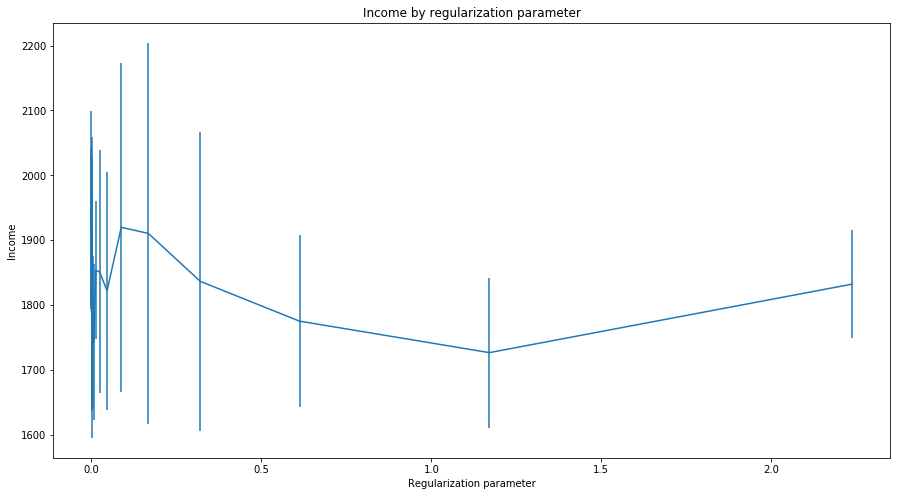

In [713]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
plt.errorbar(np.logspace(-5, 0.35, 20), incomes, yerr=deviations)
plt.title('Income by regularization parameter')
plt.xlabel('Regularization parameter')
plt.ylabel('Income')
plt.show()

In [714]:
incomes

[1917.7534380718473,
 1949.672407651959,
 1921.5956396488814,
 1871.75951498566,
 1849.9290100356477,
 1789.3797279231883,
 1819.008307891473,
 1761.3787079384147,
 1801.1064687026378,
 1759.3245212928045,
 1742.7424985749458,
 1853.2151569742116,
 1851.1006863806456,
 1821.7945799917536,
 1919.7859265177,
 1910.2967664001735,
 1836.390990810872,
 1775.0063985354107,
 1726.4432917437418,
 1832.1930152783702]

Судя по графику и значениям прибыли, всё распределено рандомно

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [715]:
for i in range(5):
    best_c = None
    best_income = 0

    incomes = list()
    deviations = list()

    for c in np.logspace(-5, 0.35, 20):
        mean_income = 0
        stds = list()
        for train_index, test_index in kf.split(X_ohe):
            X_n = X_ohe.to_numpy()
            X_train, X_test, y_train, y_test = X_n[train_index], X_n[test_index], y[train_index], y[test_index]
            logit = LogisticRegression(solver='lbfgs', C=c)
            logit.fit(X_train, y_train)
            preds = logit.predict(X_test) * y_test
            mean_income += np.sum(preds * np.random.uniform(0, 20, len(preds)))
            stds.append(np.sum(preds * np.random.uniform(0, 20, len(preds))))
        mean_income /= 5
        if mean_income > best_income:
            best_income = mean_income
            best_c = c
        incomes.append(mean_income)
        deviations.append(np.std(stds))
    
    print('Iteration: {}, best_c: {}, income: {}'.format(i + 1, best_c, best_income))

Iteration: 1, best_c: 1.912400935052277e-05, income: 1981.4918293531384
Iteration: 2, best_c: 0.3200834046599764, income: 1924.1809971290247
Iteration: 3, best_c: 0.1673725413919162, income: 1979.1069442167995
Iteration: 4, best_c: 1.912400935052277e-05, income: 1981.3029091772623
Iteration: 5, best_c: 1e-05, income: 2006.7535228434813


Выбор С зависит от конкретных значений в равномерном распределении, но склоняется в сторону маленьких значений. Прибыль при этом +- на одном уровне.

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ думаю тут важнее recall. Грубо говоря мы можем ошибиться и позвонить не тому, потому что ~~батракам~~ операторам колл-центра не так много платить за звонок. При этом потенциально согласный клиент приносит много денег



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [719]:
incomes = list()
deviations = list()
best_income = 0
best_thr = None

for thr in np.linspace(0, 1, 100):
    mean_income = 0
    stds = list()
    for train_index, test_index in kf.split(X_ohe):
        X_n = X_ohe.to_numpy()
        X_train, X_test, y_train, y_test = X_n[train_index], X_n[test_index], y[train_index], y[test_index]
        logit = LogisticRegression(solver='lbfgs')
        logit.fit(X_train, y_train)
        preds_probas = logit.predict_proba(X_test)[:, 1]
        preds = (preds_probas > thr) 
        mean_income += (np.sum(preds * y_test * np.random.uniform(0, 20, len(preds))) - np.sum(preds))
        stds.append((np.sum(preds * y_test * np.random.uniform(0, 20, len(preds))) - np.sum(preds)))
    mean_income /= 5
    if mean_income > best_income:
        best_income = mean_income
        best_thr = thr
    incomes.append(mean_income)
    deviations.append(np.std(stds))

In [720]:
best_thr, best_income

(0.10101010101010102, 4096.256540612094)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

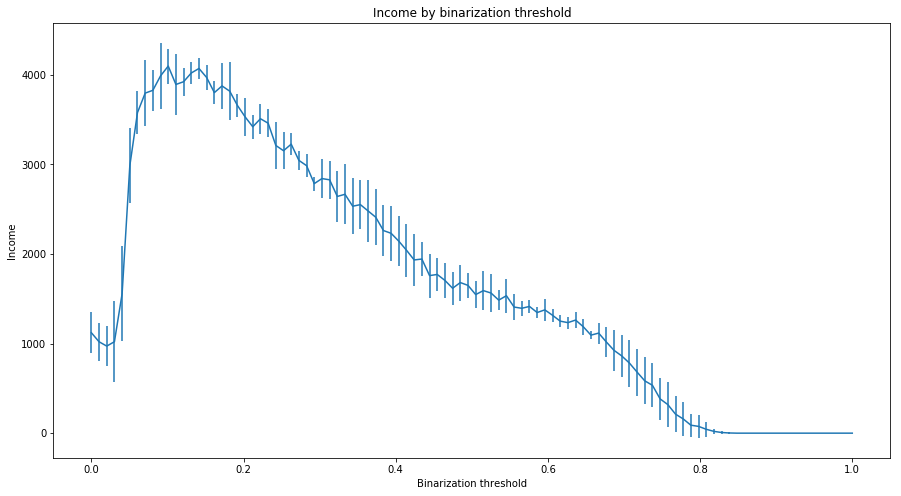

In [724]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
plt.errorbar(np.linspace(0, 1, 100), incomes, yerr=deviations)
plt.title('Income by binarization threshold')
plt.xlabel('Binarization threshold')
plt.ylabel('Income')
plt.show()

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [727]:
from sklearn.metrics import precision_score, recall_score

kf = KFold(n_splits=5, random_state=500, shuffle=True)
precisions = list()
recalls = list()
for train_index, test_index in kf.split(X_ohe):
    X_n = X_ohe.to_numpy()
    X_train, X_test, y_train, y_test = X_n[train_index], X_n[test_index], y[train_index], y[test_index]
    logit = LogisticRegression(solver='lbfgs')
    logit.fit(X_train, y_train)
    preds_proba = logit.predict_proba(X_test)[:, 1]
    preds = (preds_proba > best_thr)
    precisions.append(precision_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))
print('Precision: {}, stds: {}'.format(np.mean(precisions), np.std(precisions)))
print('Recall: {}, stds: {}'.format(np.mean(recalls), np.std(recalls)))

Precision: 0.2573678985742333, stds: 0.015291692723493053
Recall: 0.7002283058397631, stds: 0.014822846556008224


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [23]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ а какая разница, что я кушал, если не чувствую ни вкусов, ни запахов. Вот просыпаешься ты такой с мыслью вточить омлет с беконом и грибами, а может быть добавить туда ветчины и сыра, а может вообще сырников заказать или сделать кашу с ягодами и бананом? А потом приходишь на кухню и понимаешь, что не будешь есть ни омлет, ни сырники, ни кашу, а будешь есть просто еду :(